# Environment setup

## Download code and data


In [1]:
!pip install imagecodecs tifffile

     |████████████████████████████████| 17.9MB 28.2MB/s 


In [1]:
# Clone the GitHub repository and cd into it
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

Cloning into 'ml-segmentation-project'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 127 (delta 68), reused 67 (delta 28), pack-reused 0
Receiving objects: 100% (127/127), 903.48 KiB | 6.90 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/ml-segmentation-project


In [5]:
# Download the data using the fetch script
!./fetch-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.8M  100 72.8M    0     0  7049k      0  0:00:10  0:00:10 --:--:-- 8360k


## Useful imports and settings

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.morphology import binary_dilation
import os,sys
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import unet
from dataset import CellSegmentationDataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [7]:
BATCH_SIZE = 2
TRAIN_PERCENT = 0.8
CLASS_NUMBER = 3 '1 for binary classification'

img_transforms = transforms.Compose([
      # Convert to 0-1 float
      transforms.Lambda(lambda img: (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img))),  
      transforms.ToTensor(),
      transforms.CenterCrop(1024),
])
img_bound_transforms = transforms.Compose([
      # Convert to 0-1 float
      transforms.Lambda(lambda img: (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img))), 
      transforms.Lambda(lambda img: img + binary_dilation(img)),
      transforms.ToTensor(),
      transforms.CenterCrop(1024),
])
target_transforms = transforms.Compose([
      transforms.Lambda(lambda img: img.astype(np.float32)),
      transforms.ToTensor(),
      # Limit to 0-1 for foreground-background segmentation
      transforms.Lambda(lambda img: img.clamp(max=1.0)),
      transforms.CenterCrop(1024),
])

full_dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  pattern="Neuroblastoma",
                                  transform=img_bound_transforms,
                                  target_transform=target_transforms,
                                )

train_size = int(len(full_dataset) * TRAIN_PERCENT)
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Training

In [8]:
model = unet.UNet(out_channels=CLASS_NUMBER).to(device)

In [9]:
summary(model, input_size=(1, 1024, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             640
              ReLU-2       [-1, 64, 1024, 1024]               0
            Conv2d-3       [-1, 64, 1024, 1024]          36,928
              ReLU-4       [-1, 64, 1024, 1024]               0
         MaxPool2d-5         [-1, 64, 512, 512]               0
            Conv2d-6        [-1, 128, 512, 512]          73,856
              ReLU-7        [-1, 128, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]         147,584
              ReLU-9        [-1, 128, 512, 512]               0
        MaxPool2d-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 256, 256, 256]         295,168
             ReLU-12        [-1, 256, 256, 256]               0
           Conv2d-13        [-1, 256, 256, 256]         590,080
             ReLU-14        [-1, 256, 2

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


We first define the evaluation functions we'll be using during training.

In [ ]:
def combined_loss(output, label, criterion, bce_weight=.5):
  CE_loss = criterion(output, label)
  dice = dice_loss(output, label)
  comb_loss = dice * bce_weight + CE_loss (1 - bce_weight)
  return comb_loss

In [8]:
def dice_loss(output, label, smooth = 1.):
    output = F.softmax(output, dim=1)
    output = output.contiguous()
    label = label.contiguous()    

    intersection = (output * label).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (output.sum(dim=2).sum(dim=2) + label.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [9]:
def evaluate(model, loader):
    n_val = len(loader)
    tot = 0
    for image, labels in loader:
        with torch.no_grad():
            pred = model(image.to(device))
            tot += dice_loss(pred, labels.to(device))
    return tot / n_val

In [10]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Training phase
        model.train()

        epoch_loss = 0
        epoch_dice_loss = 0
        epoch_samples = len(train_loader)
            
        torch.cuda.empty_cache()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)              
            # zero the parameter gradients
            optimizer.zero_grad()   
            outputs = model(inputs)
            loss = combined_loss(output, labels, criterion)
            loss.backward()
            optimizer.step()    
            epoch_loss += loss.item()
            epoch_dice_loss += dice_loss(outputs, labels).item()

        #scheduler.step()
        
        print("Epoch train loss: {}".format(epoch_loss / epoch_samples))
        print("Epoch dice loss: {}".format(epoch_dice_loss / epoch_samples))

        # Evaluation phase
        model.eval()
        val_loss = evaluate(model, val_loader)
        if val_loss < best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())

        print("Epoch validation loss: {}".format(val_loss))

        time_elapsed = time.time() - since
        print('Took {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model

In [11]:
TRN_EPOCHS = 20
WEIGHT_DECAY = 0
LEARNING_RATE = 0.001
MOMENTUM = 0.99

torch.cuda.empty_cache()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
# Maybe interesting to use later
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

model = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=TRN_EPOCHS)

Epoch 1/20
----------
Epoch train loss: 9.658852475030082
Epoch dice loss: 0.8152329155376979
Epoch validation loss: 0.9999672770500183
Took 0m 46s

Epoch 2/20
----------
Epoch train loss: 3.732621418578284
Epoch dice loss: 0.7533765435218811
Epoch validation loss: 0.6088840663433075
Took 0m 49s

Epoch 3/20
----------
Epoch train loss: 0.5474211658750262
Epoch dice loss: 0.6001542295728411
Epoch validation loss: 0.5108586549758911
Took 0m 49s

Epoch 4/20
----------
Epoch train loss: 0.4349142185279301
Epoch dice loss: 0.5555081750665393
Epoch validation loss: 0.3940790891647339
Took 0m 49s

Epoch 5/20
----------
Epoch train loss: 0.2992078512907028
Epoch dice loss: 0.41445744037628174
Epoch validation loss: 0.2676980495452881
Took 0m 48s

Epoch 6/20
----------
Epoch train loss: 0.19300088712147304
Epoch dice loss: 0.2525578737258911
Epoch validation loss: 0.1555762141942978
Took 0m 48s

Epoch 7/20
----------
Epoch train loss: 0.17278473930699484
Epoch dice loss: 0.15776767475264414
Epo

# Generating predictions

We now generate predictions for one batch of data and compare it to the ground truth.

In [12]:
inputs, labels = next(iter(val_loader))
with torch.no_grad():
    outputs = model.predict(inputs.to(device))
    outputs = F.softmax(outputs, dim=1)

<Figure size 432x288 with 0 Axes>

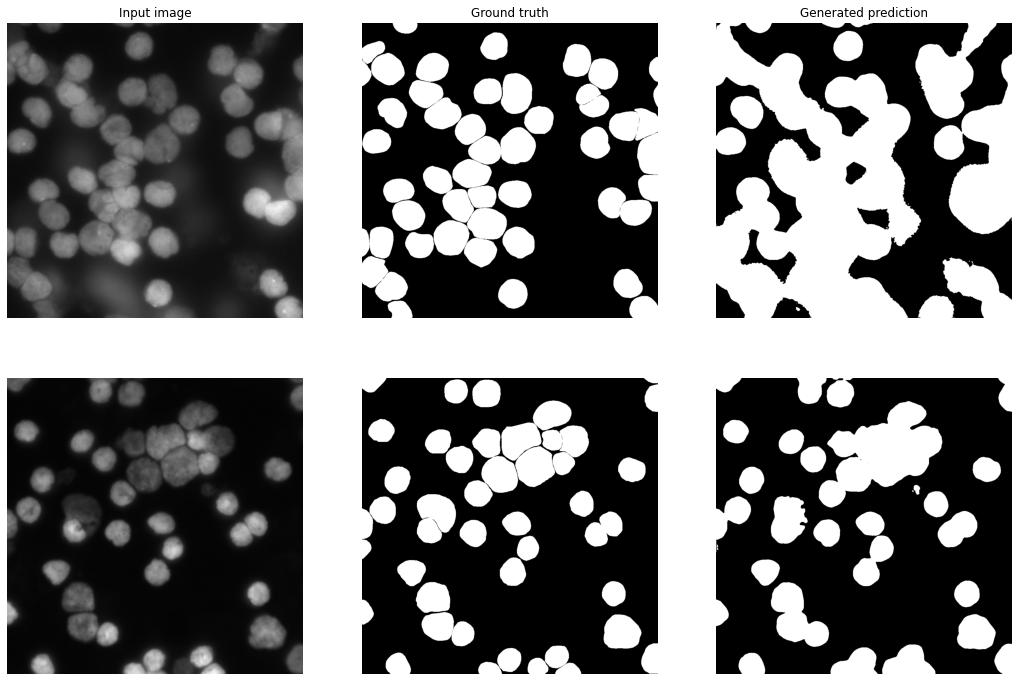

In [13]:
plt.gray()
count = len(inputs)
fig = plt.figure(figsize=(6 * 3, 6 * count))
axs = fig.subplots(count, 3)

for ax in axs.flat:
    ax.axis("off")

column_labels = ["Input image", "Ground truth", "Generated prediction"]
for ax, label in zip(axs[0], column_labels):
    ax.set_title(label)

for i in range(count):
    axs[i, 0].imshow(inputs[i].cpu().squeeze())
    axs[i, 1].imshow(labels[i].cpu().squeeze())
    axs[i, 2].imshow(outputs[i].cpu().squeeze())

fig.show()

In [60]:
image = labels[0,:,:,:].numpy().squeeze()

In [65]:
np.unique(image + scipy.ndimage.morphology.binary_dilation(image))

array([0., 1., 2.], dtype=float32)

In [63]:
final = image + scipy.ndimage.morphology.binary_dilation(image)
final_bound = final
final_bound[final_bound==2] = 0
final_no_bound = final
final_no_bound[final_no_bound==1] = 0
final_no_bound[final_no_bound==2] = 1

In [35]:
edges = image - scipy.ndimage.morphology.binary_dilation(image)
edges[edges==-1] = 1

In [41]:
dilation = scipy.ndimage.morphology.binary_dilation(image)

<Figure size 432x288 with 0 Axes>

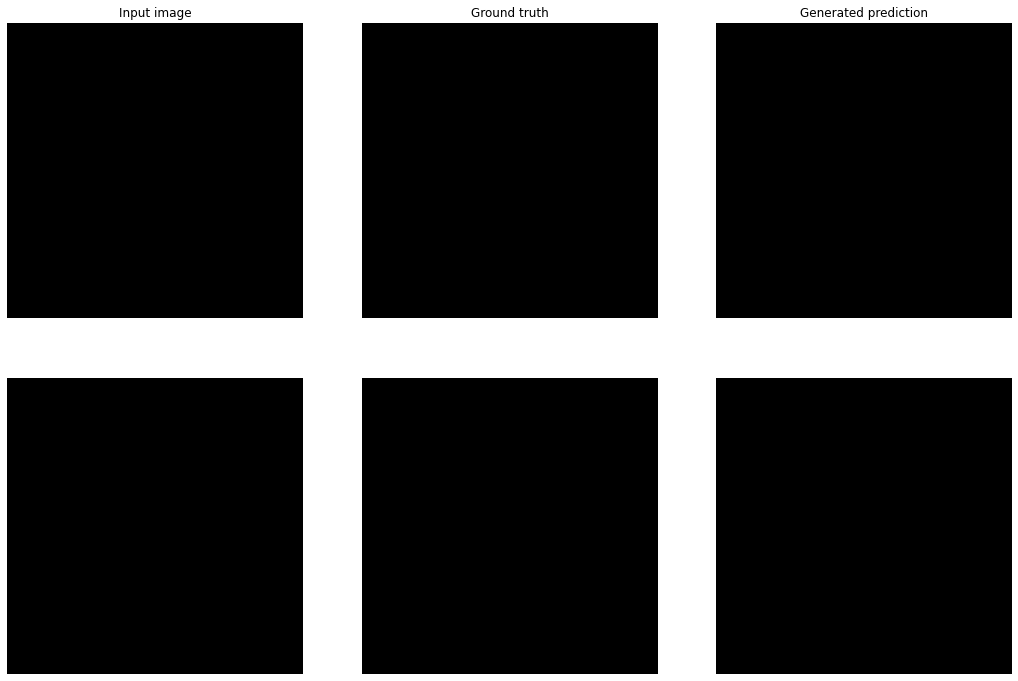

In [53]:
plt.gray()
count = len(inputs)
fig = plt.figure(figsize=(6 * 3, 6 * count))
axs = fig.subplots(count, 3)

for ax in axs.flat:
    ax.axis("off")

column_labels = ["Input image", "Ground truth", "Generated prediction"]
for ax, label in zip(axs[0], column_labels):
    ax.set_title(label)

for i in range(count):
    axs[i, 0].imshow(final)
    axs[i, 1].imshow(final_no_bound)
    axs[i, 2].imshow(final_bound)

fig.show()

In [14]:
from sklearn.metrics import jaccard_similarity_score as jsc
print(jsc(target,lbl))

NameError: ignored